In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [3]:
import logging
import os
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from loren_frank_data_processing import save_xarray
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)
from replay_trajectory_classification import (ClusterlessClassifier,
                                              SortedSpikesClassifier)
from scipy.ndimage import label
from tqdm.auto import tqdm

from src.analysis import (get_linear_position_order, get_place_field_max,
                          get_replay_info, reshape_to_segments)
from src.load_data import load_data
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)
from src.visualization import (plot_category_counts, plot_category_duration,
                               plot_neuron_place_field_2D_1D_position,
                               plot_ripple_decode_1D, plot_ripple_decode_2D)

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [4]:
epoch_key = "remy", 37, 4
ripple_number = 50

In [5]:
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key)

06-Mar-20 15:56:12 Loading data...
06-Mar-20 15:57:26 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
06-Mar-20 15:57:26 No DIO file found, using distance from well to segment trials
06-Mar-20 15:57:26 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
06-Mar-20 15:57:26 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 15:57:58 Finding ripple times...
06-Mar-20 16:01:38 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
06-Mar-20 16:01:38 No DIO file found, using distance from well to segment trials
06-Mar-20 16:01:39 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO37.mat
06-Mar-20 16:01:39 No DIO file found, inferring correct inbound/outbound from task rules


In [6]:
is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

In [12]:
logging.info('Fitting classifier...')

continuous_transition_types = (
    [['random_walk', 'uniform', 'uniform'],  # noqa
     ['uniform',     'uniform', 'uniform'],   # noqa
     ['uniform', 'uniform', 'identity']])  # noqa

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
        position, data['multiunit'], is_training=is_training,
        track_graph=track_graph, center_well_id=center_well_id,
        edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)
logging.info(classifier)

06-Mar-20 16:06:57 Fitting classifier...
06-Mar-20 16:06:57 Fitting initial conditions...
06-Mar-20 16:06:57 Fitting state transition...
06-Mar-20 16:06:58 Fitting multiunits...
06-Mar-20 16:07:01 ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'uniform'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['uniform', 'uniform',
                                                    'identity']],
                      discrete_transition_diag=0.98,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([24., 24

In [14]:
start_time, end_time = data['ripple_times'].loc[ripple_number, ["start_time", "end_time"]]

In [20]:
m = data["multiunit"].sel(time=slice(start_time, end_time))

result = classifier.predict(m, time=m.time)

In [26]:
result = result.assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))
result

<xarray.Dataset>
Dimensions:            (position: 109, state: 3, time: 72)
Coordinates:
  * time               (time) timedelta64[ns] 01:27:51.731333 ... 01:27:51.873333
  * position           (position) float64 1.464 4.391 7.319 ... 338.4 341.3
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 0.851 0.7817 ... 0.7599
    causal_posterior   (time, state, position) float64 0.008668 ... 0.0002594
    acausal_posterior  (time, state, position) float64 0.001033 ... 0.0002594

In [22]:
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
ripple_position = reshape_to_segments(position, ripple_times)

Text(0.5, 0.98, 'ripple number = remy_37_04_0050')

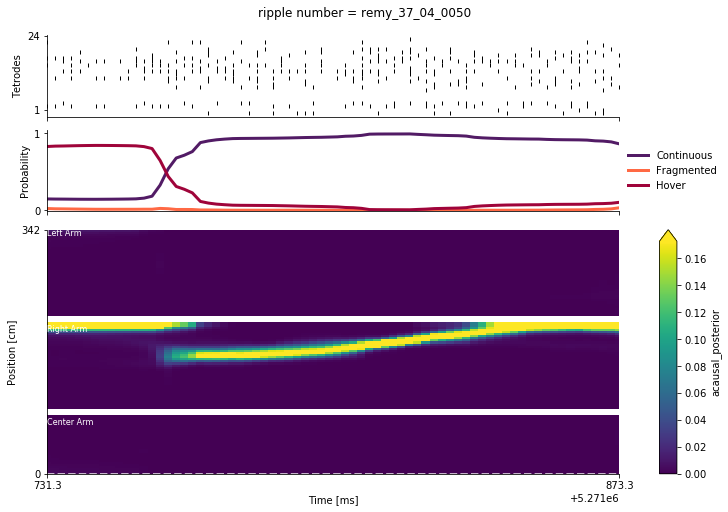

In [27]:
posterior = (
    result
    .acausal_posterior
    .dropna('time', how='all')
    .assign_coords(
        time=lambda ds: 1000 * ds.time /
        np.timedelta64(1, 's')))
plot_ripple_decode_1D(
    posterior, ripple_position.loc[ripple_number],
    ripple_spikes.loc[ripple_number], linear_position_order,
    data['position_info'], classifier, spike_label='Tetrodes')
plt.suptitle(
    f'ripple number = {animal}_{day:02d}_{epoch:02d}_'
    f'{ripple_number:04d}')

## 3

In [28]:
epoch_key = "bon", 3, 6
ripple_number = 181

06-Mar-20 16:15:41 Loading data...
06-Mar-20 16:16:30 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
06-Mar-20 16:16:30 No DIO file found, using distance from well to segment trials
06-Mar-20 16:16:31 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
06-Mar-20 16:16:31 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:17:07 Finding ripple times...
06-Mar-20 16:19:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
06-Mar-20 16:19:21 No DIO file found, using distance from well to segment trials
06-Mar-20 16:19:21 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
06-Mar-20 16:19:21 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:19:49 Fitting classifier...
06-Mar-20 16:19:49 Fitting initial conditions...
06-Mar-20 16:19:49 Fitting state transition...
0

Text(0.5, 0.98, 'ripple number = bon_03_06_0181')

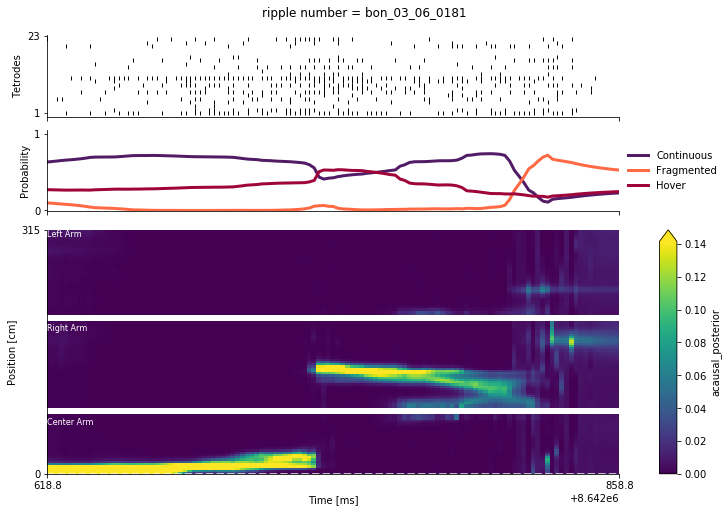

In [29]:
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key)

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

logging.info('Fitting classifier...')

continuous_transition_types = (
    [['random_walk', 'uniform', 'uniform'],  # noqa
     ['uniform',     'uniform', 'uniform'],   # noqa
     ['uniform', 'uniform', 'identity']])  # noqa

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
        position, data['multiunit'], is_training=is_training,
        track_graph=track_graph, center_well_id=center_well_id,
        edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)
logging.info(classifier)

start_time, end_time = data['ripple_times'].loc[ripple_number, ["start_time", "end_time"]]
m = data["multiunit"].sel(time=slice(start_time, end_time))
result = classifier.predict(m, time=m.time)
result = result.assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
ripple_position = reshape_to_segments(position, ripple_times)

posterior = (
    result
    .acausal_posterior
    .dropna('time', how='all')
    .assign_coords(
        time=lambda ds: 1000 * ds.time /
        np.timedelta64(1, 's')))
plot_ripple_decode_1D(
    posterior, ripple_position.loc[ripple_number],
    ripple_spikes.loc[ripple_number], linear_position_order,
    data['position_info'], classifier, spike_label='Tetrodes')
plt.suptitle(
    f'ripple number = {animal}_{day:02d}_{epoch:02d}_'
    f'{ripple_number:04d}')

# 3

In [30]:
epoch_key = "bon", 7, 2
ripple_number = 13

06-Mar-20 16:20:10 Loading data...
06-Mar-20 16:21:01 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
06-Mar-20 16:21:01 No DIO file found, using distance from well to segment trials
06-Mar-20 16:21:01 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
06-Mar-20 16:21:01 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:21:41 Finding ripple times...
06-Mar-20 16:23:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
06-Mar-20 16:23:59 No DIO file found, using distance from well to segment trials
06-Mar-20 16:24:00 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO07.mat
06-Mar-20 16:24:00 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:24:32 Fitting classifier...
06-Mar-20 16:24:32 Fitting initial conditions...
06-Mar-20 16:24:32 Fitting state transition...
0

Text(0.5, 0.98, 'ripple number = bon_07_02_0013')

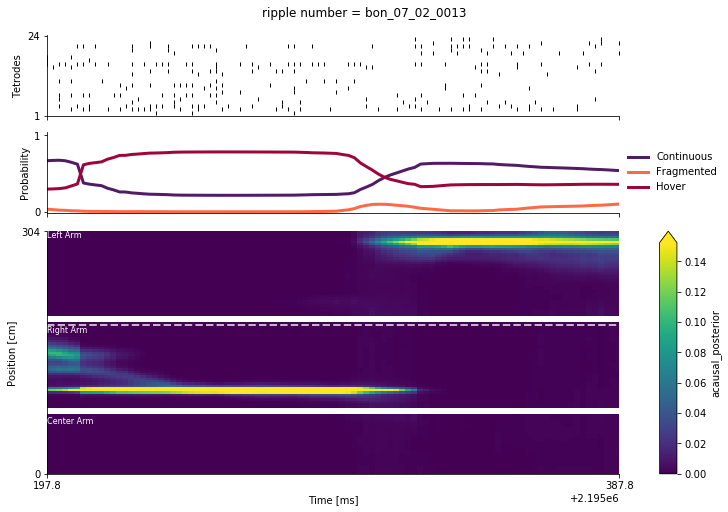

In [31]:
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key)

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

logging.info('Fitting classifier...')

continuous_transition_types = (
    [['random_walk', 'uniform', 'uniform'],  # noqa
     ['uniform',     'uniform', 'uniform'],   # noqa
     ['uniform', 'uniform', 'identity']])  # noqa

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
        position, data['multiunit'], is_training=is_training,
        track_graph=track_graph, center_well_id=center_well_id,
        edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)
logging.info(classifier)

start_time, end_time = data['ripple_times'].loc[ripple_number, ["start_time", "end_time"]]
m = data["multiunit"].sel(time=slice(start_time, end_time))
result = classifier.predict(m, time=m.time)
result = result.assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
ripple_position = reshape_to_segments(position, ripple_times)

posterior = (
    result
    .acausal_posterior
    .dropna('time', how='all')
    .assign_coords(
        time=lambda ds: 1000 * ds.time /
        np.timedelta64(1, 's')))
plot_ripple_decode_1D(
    posterior, ripple_position.loc[ripple_number],
    ripple_spikes.loc[ripple_number], linear_position_order,
    data['position_info'], classifier, spike_label='Tetrodes')
plt.suptitle(
    f'ripple number = {animal}_{day:02d}_{epoch:02d}_'
    f'{ripple_number:04d}')

In [32]:
##

In [33]:
epoch_key = "remy", 36, 4
ripple_number = 43

06-Mar-20 16:24:46 Loading data...
06-Mar-20 16:25:58 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
06-Mar-20 16:25:58 No DIO file found, using distance from well to segment trials
06-Mar-20 16:25:59 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
06-Mar-20 16:25:59 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:26:31 Finding ripple times...
06-Mar-20 16:30:02 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
06-Mar-20 16:30:02 No DIO file found, using distance from well to segment trials
06-Mar-20 16:30:03 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Remy/remyDIO36.mat
06-Mar-20 16:30:03 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:30:55 Fitting classifier...
06-Mar-20 16:30:55 Fitting initial conditions...
06-Mar-20 16:30:55 Fitting state transition.

Text(0.5, 0.98, 'ripple number = remy_36_04_0043')

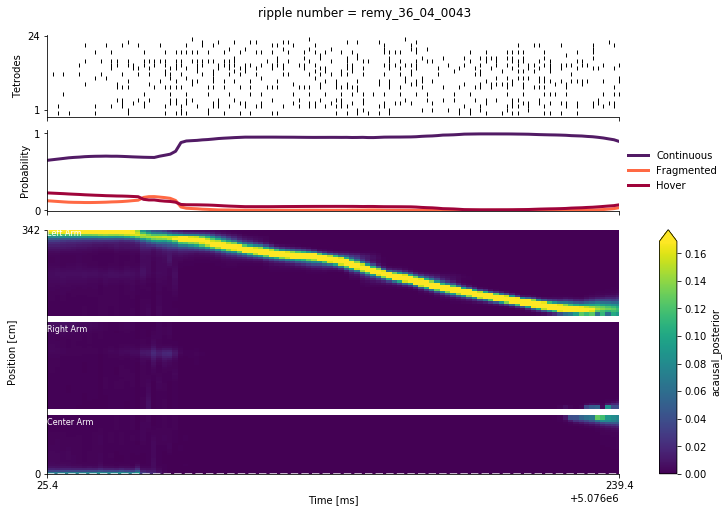

In [34]:
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key)

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

logging.info('Fitting classifier...')

continuous_transition_types = (
    [['random_walk', 'uniform', 'uniform'],  # noqa
     ['uniform',     'uniform', 'uniform'],   # noqa
     ['uniform', 'uniform', 'identity']])  # noqa

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
        position, data['multiunit'], is_training=is_training,
        track_graph=track_graph, center_well_id=center_well_id,
        edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)
logging.info(classifier)

start_time, end_time = data['ripple_times'].loc[ripple_number, ["start_time", "end_time"]]
m = data["multiunit"].sel(time=slice(start_time, end_time))
result = classifier.predict(m, time=m.time)
result = result.assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
ripple_position = reshape_to_segments(position, ripple_times)

posterior = (
    result
    .acausal_posterior
    .dropna('time', how='all')
    .assign_coords(
        time=lambda ds: 1000 * ds.time /
        np.timedelta64(1, 's')))
plot_ripple_decode_1D(
    posterior, ripple_position.loc[ripple_number],
    ripple_spikes.loc[ripple_number], linear_position_order,
    data['position_info'], classifier, spike_label='Tetrodes')
plt.suptitle(
    f'ripple number = {animal}_{day:02d}_{epoch:02d}_'
    f'{ripple_number:04d}')

##

In [35]:
epoch_key = "fra", 11, 4
ripple_number = 1

06-Mar-20 16:31:27 Loading data...
06-Mar-20 16:32:19 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
06-Mar-20 16:32:19 No DIO file found, using distance from well to segment trials
06-Mar-20 16:32:20 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
06-Mar-20 16:32:20 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:32:50 Finding ripple times...
06-Mar-20 16:35:05 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
06-Mar-20 16:35:05 No DIO file found, using distance from well to segment trials
06-Mar-20 16:35:07 Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Frank/fraDIO11.mat
06-Mar-20 16:35:07 No DIO file found, inferring correct inbound/outbound from task rules
06-Mar-20 16:35:30 Fitting classifier...
06-Mar-20 16:35:30 Fitting initial conditions...
06-Mar-20 16:35:30 Fitting state transition.

Text(0.5, 0.98, 'ripple number = fra_11_04_0001')

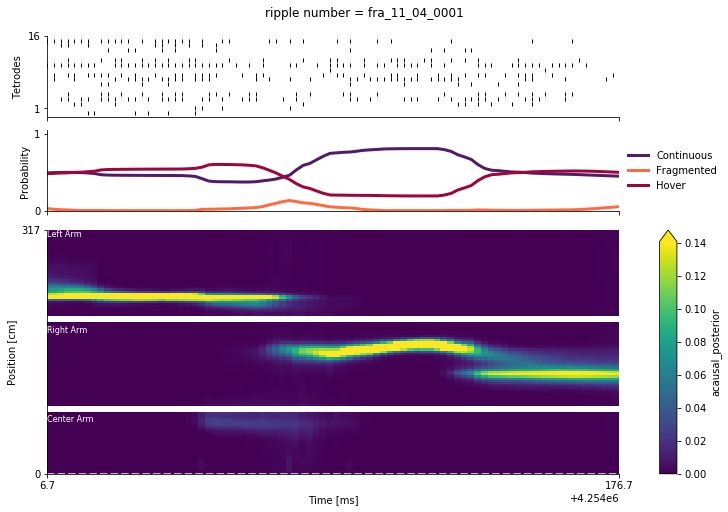

In [36]:
animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key)

is_training = data['position_info'].speed > 4
position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

model_name = os.path.join(
    PROCESSED_DATA_DIR,
    f'{animal}_{day:02}_{epoch:02}_{data_type}_{dim}_model.pkl')

logging.info('Fitting classifier...')

continuous_transition_types = (
    [['random_walk', 'uniform', 'uniform'],  # noqa
     ['uniform',     'uniform', 'uniform'],   # noqa
     ['uniform', 'uniform', 'identity']])  # noqa

classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
        position, data['multiunit'], is_training=is_training,
        track_graph=track_graph, center_well_id=center_well_id,
        edge_order=EDGE_ORDER, edge_spacing=EDGE_SPACING)
logging.info(classifier)

start_time, end_time = data['ripple_times'].loc[ripple_number, ["start_time", "end_time"]]
m = data["multiunit"].sel(time=slice(start_time, end_time))
result = classifier.predict(m, time=m.time)
result = result.assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY))

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
ripple_position = reshape_to_segments(position, ripple_times)

posterior = (
    result
    .acausal_posterior
    .dropna('time', how='all')
    .assign_coords(
        time=lambda ds: 1000 * ds.time /
        np.timedelta64(1, 's')))
plot_ripple_decode_1D(
    posterior, ripple_position.loc[ripple_number],
    ripple_spikes.loc[ripple_number], linear_position_order,
    data['position_info'], classifier, spike_label='Tetrodes')
plt.suptitle(
    f'ripple number = {animal}_{day:02d}_{epoch:02d}_'
    f'{ripple_number:04d}')